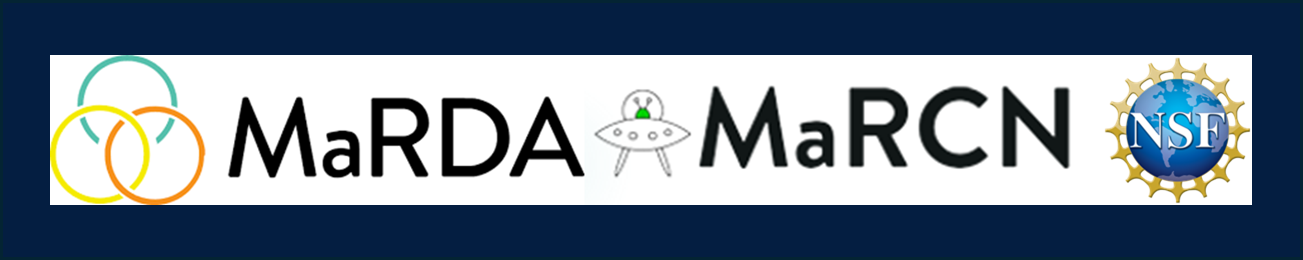

# FAIR Application using Tensile Testing Ontology

Authors: [Erwin Cazares<sup>1</sup>](ecazares3@miners.utep.edu), [Dr Brian E. Schuster<sup>1</sup>](bschuster@utep.edu) </br>

<sup>1</sup> Dynamic Materials Laboratory at University of Texas at El Paso, TX USA 79968</br>

Date of creation: Summer 2024 </br>
Date of last revision: Summer 2024 </br>

# Using Tensile Test Report to Build RDF Graph

This notebook is designed to analyze a single experiment of tensile data for Aluminium 6061. The analysis results, including various mechanical properties, are saved using the [PMDco TTO ontology](https://github.com/materialdigital/application-ontologies/tree/main/tensile_test_ontology_TTO). The notebook outputs several images and a text file containing detailed analysis results.

## Dataset Used
The dataset consists of tensile test report data for Aluminium 6061. This data is used to compute and visualize different mechanical properties of the material.

## Notebook Structure

The notebook is organized into the following sections:

1. **Introduction and Setup:** Provides an overview of the tensile data analysis and specifies the working directories.

  
2. **Data Loading:** Loads the tensile test data from specified directories.

3. **Analysis and Calculation:** Computes various mechanical properties such as Young's Modulus, 0.2% Yield Strength, Modulus of Resilience, Strain Energy Density at 0.2%, Toughness, Ultimate Tensile Strength (UTS), Final Strain (ef), and Elastic Recovery (er).
4. **Visualization:** Generates and saves images that visualize the computed properties and trends.

**Usage**

To effectively utilize this notebook, follow these instructions:

1. Ensure all required dependencies are installed and configured correctly. Refer to the provided documentation or requirements.txt file for guidance.
2. Specify the working directories and ensure the tensile test data is available in the correct format.
3. Run the notebook cells sequentially to perform the analysis and generate the results.

The notebook will output images and a text file containing the analysis results, which can be used for further reference and study.

## Define working directories and results path

In [2]:
import subprocess
import os

# Get the directory of the current script or the parent directory
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.path.dirname(os.getcwd())
print(f'Current working directory = {script_dir}')

def install_requirements(requirements_file):
    try:
        subprocess.check_call(['pip', 'install', '-r', requirements_file])
        print("Successfully installed dependencies from", requirements_file)
    except subprocess.CalledProcessError as e:
        print("Error installing dependencies:", e)

if __name__ == "__main__":
    requirements_file = os.path.join(script_dir, "requirements.txt")
    install_requirements(requirements_file)

Current working directory = D:\FAIR_Ontology\MaRCN_Tensile_Ontology


In [12]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from rdflib import Graph, URIRef, Literal, Namespace, RDF
import re

# Relative path to the data folder
data_folder = os.path.join(script_dir, 'data', 'ReportRaw')
print(f'Path to data folder = {data_folder}')

# Create and Append a Text File with Data
def txtEdit(text, func, file_path):
    with open(file_path, func) as file:
        file.write(text)

def stress_from_load(l,w,t,mm_in=False):
    if mm_in == True:
        wi = w/25.4
        ti = t/25.4
        area = wi*ti
    else:
        area = w*t
    strs = l/area
    return(strs)

def strain_from_displacement(d,lngth):
    strn = d/lngth
    return(strn)

def true_from_eng(a,b):
    sigma_t = np.copy(a)
    epsilon_t = np.copy(b)
    ii=0
    for ii in range(len(a)):
        sigma_t[ii] = a[ii]*(1+b[ii])
        epsilon_t[ii] = np.log(1+b[ii])
    return(sigma_t,epsilon_t)

Path to data folder = D:\FAIR_Ontology\MaRCN_Tensile_Ontology\data\ReportRaw


## Load Tensile Data from Excel Reports

- Extracts all file names from data folder and creates result folder for individual test
- Creates text file for analyzis
- Loads Load-Displacement data from excel file

In [23]:
results_folder_path = os.path.join(script_dir, 'results')
primary_data_folder = os.path.join(script_dir, 'data', 'PrimaryData')
secondary_data_folder = os.path.join(script_dir, 'data', 'SecondaryData')

# Create Results Folder
if not os.path.exists(results_folder_path):
    os.mkdir(results_folder_path)
print(f'Results folder path = {results_folder_path}')

# Collect all Excel files from subfolders
tensile_files = []
for material_folder in os.listdir(data_folder):
    material_path = os.path.join(data_folder, material_folder)
    if os.path.isdir(material_path):
        excel_files = glob.glob(os.path.join(material_path, '*.xlsx'))
        tensile_files.extend(excel_files)

# Sort the list of file paths
tensile_files = sorted(tensile_files)

# Select only one file for analysis
if tensile_files:
    fname = tensile_files[0]
    material_folder = os.path.basename(os.path.dirname(fname))
    file_name = os.path.splitext(os.path.basename(fname))[0]
    print(f'Selected file for analysis: {fname}')
    print(f'Material: {material_folder}')

    # Create a corresponding folder structure in the results directory
    result_material_folder = os.path.join(results_folder_path, material_folder, file_name)
    if not os.path.exists(result_material_folder):
        os.makedirs(result_material_folder)
    print(f'Metadata Result Folder = {result_material_folder}')

    # Path to the results file
    metadata_file_path = os.path.join(result_material_folder, 'results.txt')
    
    # Create a results file inside the result folder using txtEdit function
    txtEdit(f'Results for {file_name} in {material_folder}\n\n', 'w', metadata_file_path)
    print(f'Results file created at: {metadata_file_path}')

    # Read the selected Excel file
    try:
        df = pd.read_excel(fname, sheet_name='Sheet2', header=None)
        print("Successfully read the Excel file.")
    except Exception as e:
        print("Error occurred while reading the Excel file:", e)
        txtEdit('Data Name Convention Breached\n\n', 'a', metadata_file_path)
else:
    print("No Excel files found in the specified directory.")

Results folder path = D:\FAIR_Ontology\MaRCN_Tensile_Ontology\results
Selected file for analysis: D:\FAIR_Ontology\MaRCN_Tensile_Ontology\data\ReportRaw\Aluminium_6061\Tensile_001.xlsx
Material: Aluminium_6061
Metadata Result Folder = D:\FAIR_Ontology\MaRCN_Tensile_Ontology\results\Aluminium_6061\Tensile_001
Results file created at: D:\FAIR_Ontology\MaRCN_Tensile_Ontology\results\Aluminium_6061\Tensile_001\results.txt
Successfully read the Excel file.


## Explore Sample Geometry

Explores the report sheet of the excel to extract the following
- Lenght
- Width
- Thickness 
- Units

It appends this info to the material's result txt file

In [52]:
#Find Column Index of mm
dfcol = df
col = dfcol
for i in range(len(col)):
    try:
        if any(dfcol.iloc[i].str.contains('mm')==True):
            breakpoint = i
            break
    #Uniformalize? the Data
    except(AttributeError):
        dfcol = dfcol.T
        dfcol.insert(0,'0',np.nan)
        dfcol = dfcol.T
        dfcol.fillna('empty',inplace=True)
        if any(dfcol.iloc[i].str.contains('mm')==True):
            breakpoint = i
            break
            
# print(dfcol.iloc[breakpoint])

# Save raw data to a DataFrame
raw_data_df = dfcol.copy() 

# Drop the first row as it contains the headers
raw_data_df = raw_data_df.iloc[1:]

# Create the folder structure if it doesn't exist
target_folder = os.path.join(primary_data_folder, material_folder)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Define the full path for the CSV file
csv_file_path = os.path.join(target_folder, file_name)

# Save the raw load-displacement data to CSV
raw_data_df.to_csv(csv_file_path + ".csv", index=False, header = ["Displacement (mm)", "Load (N)"])

print(f"Raw Data Saved to = {csv_file_path}")

try:
    df2 = pd.read_excel(fname, sheet_name='Test Report')
except:
    print('Data Name Convention Breached\n\n')
    txtEdit('Data Name Convention Breached\n\n', 'a', metadata_file_path)
    #continue
    
#Find Length
a = np.where(df2['Default Test Run Report'].str.contains('Initial Marked Gage Length')==True)
a = int(a[0])
dflen = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dflen = dflen.T
s_length = dflen.iloc[1,0]
print('Length:'+str(s_length))
txtEdit('Length:'+str(s_length)+'\n','a', metadata_file_path)
    
#Find Width
a = np.array(np.where(df2['Default Test Run Report'].str.contains('Width')==True)).flatten()
a = int(a[0])
dfw = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dfw = dfw.T
width = dfw.iloc[1,0]
print('Width:'+str(width))
txtEdit('Width:'+str(width)+'\n','a', metadata_file_path)
    
#Find Thickness
a = np.array(np.where(df2['Default Test Run Report'].str.contains('Thickness')==True)).flatten()
a = int(a[0])
dft = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dft = dft.T
thickness = dft.iloc[1,0]
print('Thickness:'+str(thickness))
txtEdit('Thickness:'+str(thickness)+'\n','a', metadata_file_path)
    
#Find Stress and Strain
try:
    dfdat = pd.read_excel(fname, sheet_name='Sheet2',skiprows=breakpoint)
    dfdat.dropna(subset=['mm'],inplace=True)
    completion = True
except:
    completion = False
 
    if completion == False:
        try:
            dfdat = pd.read_excel(fname, sheet_name='Sheet2',skiprows=breakpoint+1)
            dfdat.dropna(subset=['mm'],inplace=True)
        except:
            print('Data Layout Unsupported\n\n')
            txtEdit('Data Layout Unsupported\n\n','a', metadata_file_path)
            #continue
        
try:
    dfdat.dropna(subset=['N'],inplace=True)
    load = np.array(dfdat['N'])
    stress = stress_from_load(load,width,thickness)
    y_units = 'MPa'
    print('Units: MPa')
    txtEdit('Units: MPa'+'\n','a', metadata_file_path)
except:
    dfdat.dropna(subset=['lbf'],inplace=True)
    load = np.array(dfdat['lbf'])
    stress = stress_from_load(load,width,thickness,mm_in=True)
    y_units = 'psi'
    print('Units: psi')
    txtEdit('Units: psi'+'\n','a', metadata_file_path)
    
displacement = np.array(dfdat['mm'])
strain = strain_from_displacement(displacement,s_length)

Raw Data Saved to = D:\FAIR_Ontology\MaRCN_Tensile_Ontology\data\PrimaryData\Aluminium_6061\Tensile_001
Length:50
Width:13.49
Thickness:3.09
Units: MPa


## Generate Stress-Strain Graph 

- Cleans load-displacement data and converts it to stress-strain
- Plots and saves the result

Processed Data Saved to = D:\FAIR_Ontology\MaRCN_Tensile_Ontology\data\SecondaryData\Aluminium_6061\Tensile_001


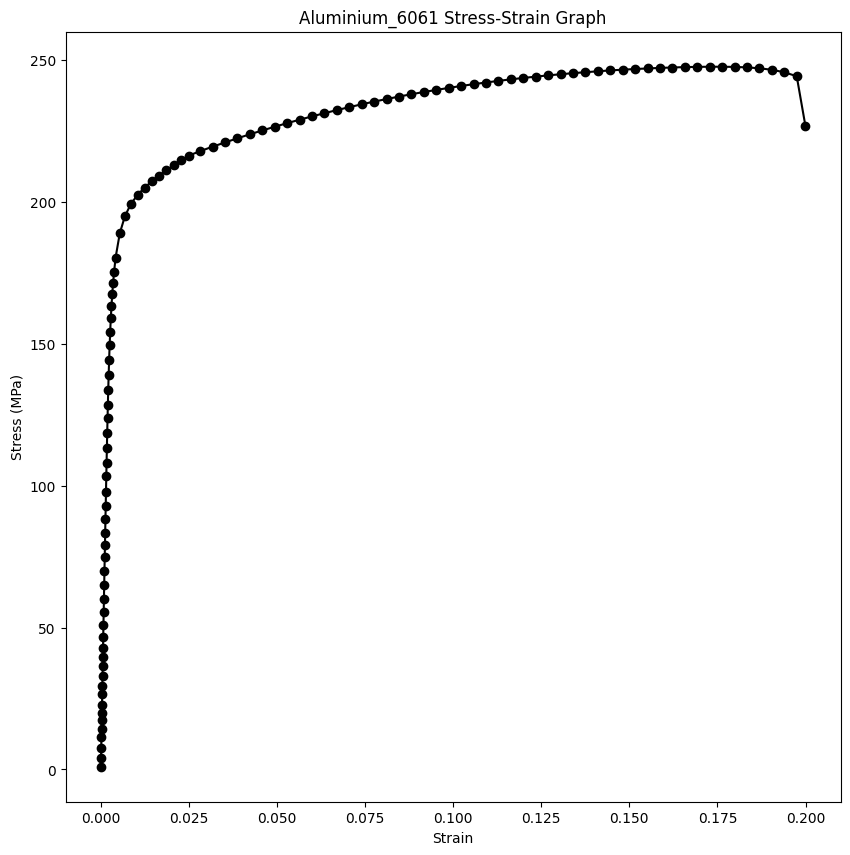

In [40]:
"""
Smooth Dataset
"""

#Set Moving Window
winSize = 25
    
smooth_x = np.array([])
smooth_y = np.array([])
length = len(stress)
j=0
while j < length - 1:
    #print("j:", j, "length:", length)  # Debugging print statement
    check = np.sign(stress[j])
    try:
        strain[j+1]
    except:
        if check < 0:
            stress = np.delete(stress, j)
            strain = np.delete(strain, j)
            break
        
    if check < 0:
        stress = np.delete(stress, j)
        strain = np.delete(strain, j)
        j = j - 1
    elif np.sign(strain[j+1] - strain[j]) < 0:
        stress = np.delete(stress, j)
        strain = np.delete(strain, j)
        j = j - 1
    else:
        pass
    length = len(stress)
    j = j + 1
 #   print(stress)
    
i = 0
while i < len(strain):
    datx = np.average(strain[i:i+winSize])
    daty = np.average(stress[i:i+winSize])
    datarrX = np.array([datx])
    datarrY = np.array([daty])
    smooth_x = np.append(smooth_x,datarrX)
    smooth_y = np.append(smooth_y,datarrY)
    i = i+winSize
    
# Create DataFrames for processed stress-strain data
processed_stress_strain_df = pd.DataFrame({'strain': smooth_x, 'stress': smooth_y})

# Create the folder structure if it doesn't exist
target_folder = os.path.join(secondary_data_folder, material_folder)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Define the full path for the CSV file
csv_file_path = os.path.join(target_folder, file_name)

# Save the raw load-displacement data to CSV
processed_stress_strain_df.to_csv(csv_file_path + ".csv", index=False, header = ["Strain", "Stress (MPa)"])

print(f"Processed Data Saved to = {csv_file_path}")

#print(smooth_x,smooth_y)
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material_folder) + ' Stress-Strain Graph'
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot True Stress-Strain Graph

- Calculates true stress and strain from and plots it alongside with the engineering stress-strain
- Saves the plot 

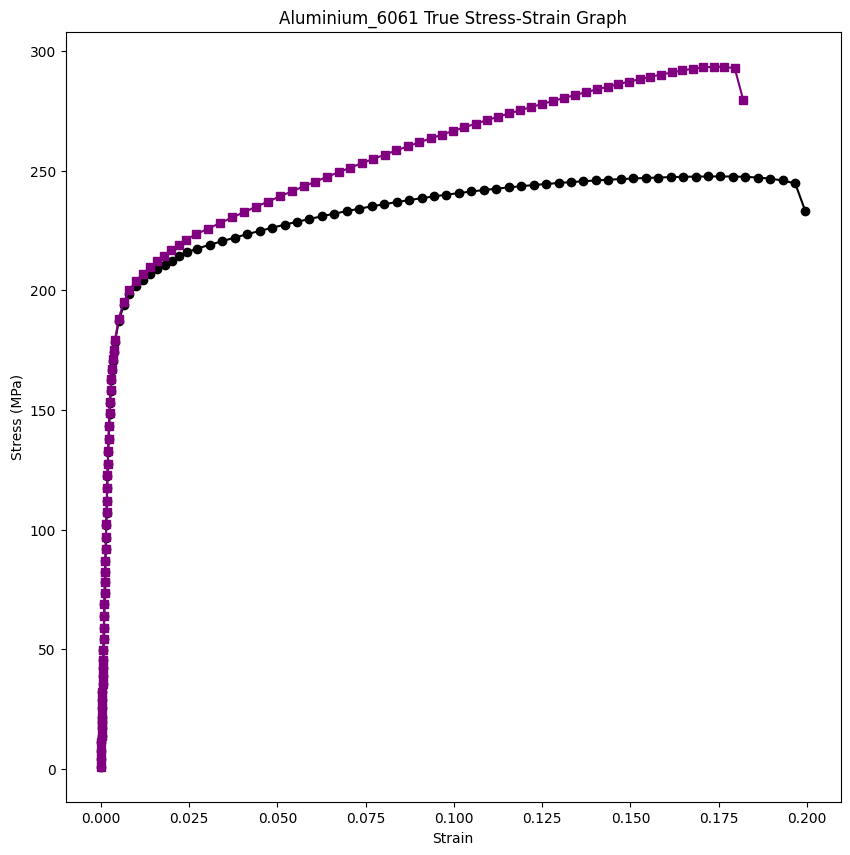

In [27]:
"""
True Stress/Strain
"""
#Call function
true_smooth_y,true_smooth_x = true_from_eng(smooth_y,smooth_x)

# Create DataFrames for processed stress-strain data
true_stress_strain_df = pd.DataFrame({'strain': true_smooth_x, 'stress': true_smooth_y})
   
#Plot True Stress/Strain
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material_folder)+' True Stress-Strain Graph'
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
plt.plot(true_smooth_x,true_smooth_y,marker='s',color='purple')
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()
smooth_y = true_smooth_y
smooth_x = true_smooth_x
    

## Calculate Young's Modulus

- Takes the Young's Modulus from a section of the linear component
- Appends result to txt file

In [31]:
"""
Young's Modulus
"""
#Find E
start=10
i=start+1
Ei = np.array([])
Eact = np.array([])
error = 0.1
pings = 0
k=1
while i < len(smooth_x):
    Epoint = (smooth_y[i]-smooth_y[i-1])/(smooth_x[i]-smooth_x[i-1])
    Earr = np.array([Epoint])
    Ei = np.append(Ei,Earr)
    Eavg = np.average(Ei)
    if i >= start+2:
        if Eavg/Ei[k-1] > (3+error) or Eavg/Ei[k-1] < (1-error):
   #       print(Ei[k-1])
            pings = pings+1
        else:
            Eact = np.append(Eact,Ei[k-1])
            pings = 0
            breakpoint = i
    else:
        pass
    
    if pings >= 5:
        Ei = np.delete(Ei,k-1)
        break
    else:
        pass
    i = i + 1
    k = k + 1
  #  print(Eact)

E = np.average(Eact)
print("Young's Modulus = {}".format(int(np.round(E,0)))+' '+ y_units)
txtEdit("Young's Modulus = {}".format(int(np.round(E,0)))+' '+y_units+'\n','a', metadata_file_path)
  #  print(breakpoint)

Young's Modulus = 55704 MPa


## Calculate Proportional Limit 

- Calculates proportional limit and adds it to the engineering stress-strain graph
- Plots and save the figure
- Appends the result to txt file

Proportional Limit = 160.55 MPa


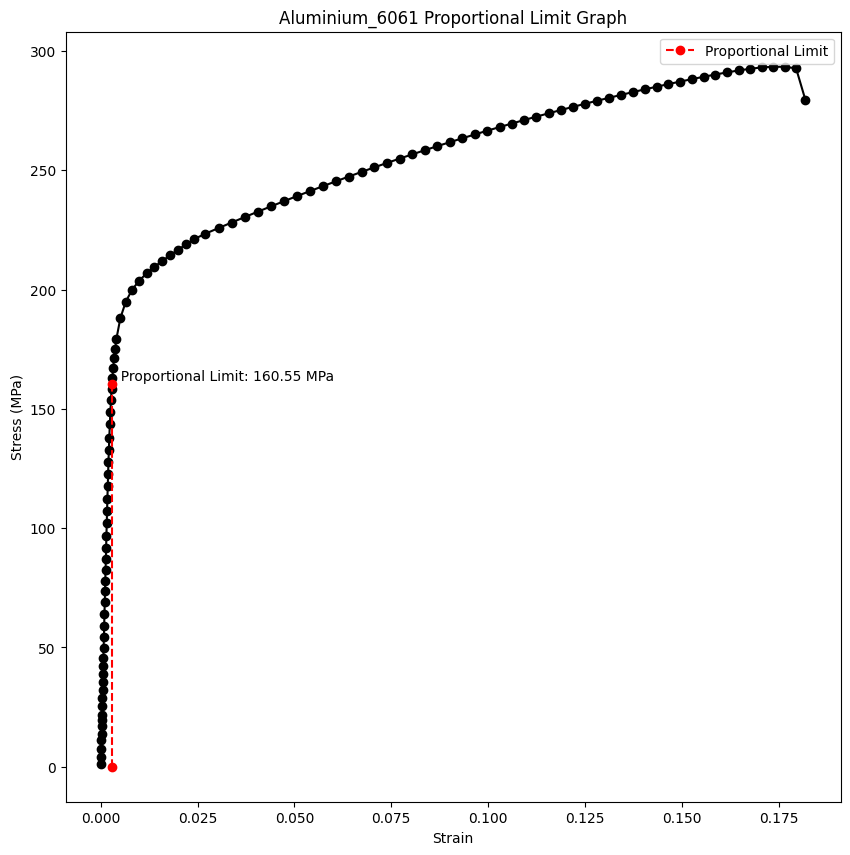

In [32]:
"""
Proportional Limit
"""
#Find Proportional Limit
length = winSize * breakpoint
winMin = length - winSize
winMax = length + winSize
small_x = np.array([])
small_y = np.array([])
sEi = np.array([])
    
winSizeSmall = 1
    
i = winMin
smallError = 0.1
k = 1
while i < winMax:
    pl = i
    sdatx = np.average(strain[i:i+winSizeSmall])
    sdaty = np.average(stress[i:i+winSizeSmall])
    sdatarrX = np.array([sdatx])
    sdatarrY = np.array([sdaty])
    small_x = np.append(small_x,sdatarrX)
    small_y = np.append(small_y,sdatarrY)
    if len(small_x) >= 2:
        sEpoint = (small_y[k-1]-small_y[k-2])/(small_x[k-1]-small_x[k-2])
        sEarr = np.array([sEpoint])
        sEi = np.append(sEi,sEarr)
        if len(sEi) >= 2:
            if sEi[k-3]/sEi[k-2] > (1+smallError) or sEi[k-3]/sEi[k-2] < (1-smallError):
                break
            else:
                pass
        else:
            pass
    else:
        pass
    k = k+1
    i = i+winSizeSmall
    
plx = np.linspace(strain[pl],strain[pl],2)
ply = np.linspace(0,stress[pl],2)

print("Proportional Limit = {:.2f} {}".format(ply[-1], y_units))
txtEdit("Proportional Limit = {:.2f} {}\n".format(ply[-1], y_units), 'a', metadata_file_path)


# Plot proportional limit
fig, ax = plt.subplots(figsize=(10, 10))
figname = f"{material_folder} Proportional Limit Graph"
plt.title(figname)
plt.ylabel('Stress (' + y_units + ')')
plt.xlabel("Strain")
plt.plot(smooth_x, smooth_y, marker='o', color='black')
plt.plot(plx, ply, marker='o', color='red', linestyle='dashed', label='Proportional Limit')
plt.legend()
plt.text(plx[-1], ply[-1], f'  Proportional Limit: {ply[-1]:.2f} {y_units}', 
         verticalalignment='bottom', horizontalalignment='left')

# Save and display the plot
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()



## Calculate the 2% Offset

- Calculates 2% Offset
- Appends result to txt file

In [33]:
"""
0.2% Offset
"""
#Find 0.2% Offset
stress_offset = np.copy(smooth_y)
strain_offset = np.copy(smooth_x)
for i in range(len(stress_offset)):
    strain_offset[i] = (stress_offset[i]/E) + 0.002
indx = int(np.argwhere(np.diff(np.sign(strain_offset-smooth_x))).flatten())
  #  print(indx)
mult = 2
length = winSize * indx
  #  print(length)
winMin = length - winSize*mult
winMax = length + winSize*mult
small_strain = np.array([])
small_stress = np.array([])
i = winMin
while i < winMax:
    offset_datx = np.average(strain[i:i+winSizeSmall])
    offset_daty = np.average(stress[i:i+winSizeSmall])
    offset_datarrX = np.array([offset_datx])
    offset_datarrY = np.array([offset_daty])
    small_strain = np.append(small_strain,offset_datarrX)
    small_stress = np.append(small_stress,offset_datarrY)
    i = i+winSizeSmall
    
stress_offset_fine = np.copy(small_stress)
strain_offset_fine = np.copy(small_strain)

for i in range(len(stress_offset_fine)):
    strain_offset_fine[i] = (stress_offset_fine[i]/E) + 0.002
    
window=winMax-winMin

###USE ONLY FOR LARGE DATA SETS
fine_indx = int(np.argwhere(np.diff(np.sign(strain_offset_fine-small_strain))).flatten())
  #  print(fine_indx)
new_indx = winMin+((fine_indx)*winSizeSmall)
  # print(new_indx)
  
print('0.2% Yield Strength = {}'.format(np.round(stress_offset_fine[fine_indx],3)) + y_units)
txtEdit('0.2% Yield Strength = {}'.format(np.round(stress_offset_fine[fine_indx],3))+y_units+'\n','a', metadata_file_path)
    
    

0.2% Yield Strength = 189.014MPa


## Calculate Modulus of Resilience

- Calculates Modulus of Resilience at Proportional Limit
- Calculates Strain Energy Density at 0.2% Offset
- Plots the regions under stress-strain graph
- Appends results to txt file

Modulus of Resilience at Proportional Limit = 0.231 MPa
Strain Energy Density at 0.2% Offset = 0.321 MPa


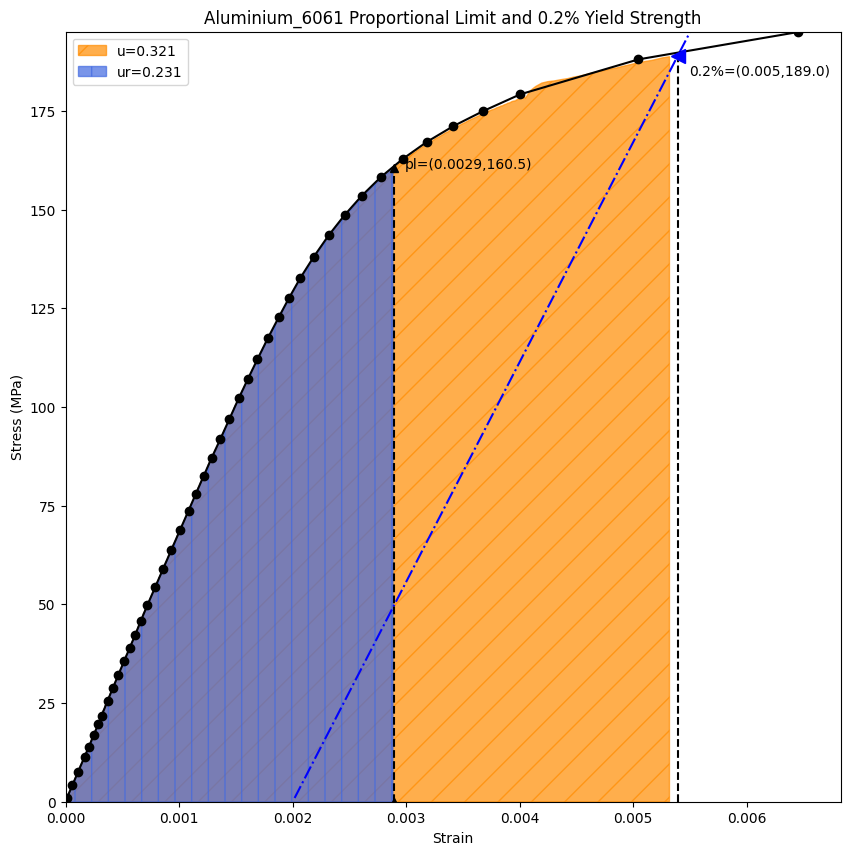

In [34]:
"""
Modulus of Resilience
"""
ur = (1/2)*(stress[pl]**2/E)
print('Modulus of Resilience at Proportional Limit = {}'.format(np.round(ur,3))+" "+y_units)
txtEdit('Modulus of Resilience at Proportional Limit = {}'.format(np.round(ur,3))+" "+y_units+'\n','a', metadata_file_path)
ur_offset = (1/2)*(stress_offset_fine[fine_indx]**2/E)
print('Strain Energy Density at 0.2% Offset = {}'.format(np.round(ur_offset,3))+" "+ y_units)
txtEdit('Strain Energy Density at 0.2% Offset = {}'.format(np.round(ur_offset,3))+" "+y_units+'\n','a', metadata_file_path)
    
#Plot Moduli of Resilience
ofst2x = np.linspace(strain_offset_fine[fine_indx],strain_offset_fine[fine_indx],2)
ofst2y = np.linspace(0,stress_offset_fine[fine_indx],2)
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material_folder)+' Proportional Limit and 0.2% Yield Strength'
plt.title(figname)
plt.xlim(0,strain[new_indx+winSize])
plt.ylim(0,stress[new_indx+winSize])
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(strain_offset,stress_offset,color='b',linestyle='-.')
plt.plot(smooth_x,smooth_y,marker='o',color='black')
plt.plot(plx,ply,marker='^',color='black',linestyle='--')
plt.plot(ofst2x,ofst2y,color='black',linestyle='--')
plt.plot(strain_offset_fine[fine_indx],stress_offset_fine[fine_indx],marker='<',color='b',markersize=10)
plt.annotate('pl=({},{})'.format(np.round(strain[pl],4),np.round(stress[pl],1)),
                (strain[pl],stress[pl]),(strain[pl]+0.0001,stress[pl]))
plt.annotate('0.2%=({},{})'.format(np.round(strain_offset_fine[fine_indx],3),
                                       np.round(stress_offset_fine[fine_indx],1)),
                 (strain_offset_fine[fine_indx],stress_offset_fine[fine_indx]),
                 (strain_offset_fine[fine_indx]+0.0001,stress_offset_fine[fine_indx]-5))
    
plt.fill_between(strain[0:new_indx],stress[0:new_indx],color='darkorange',alpha=0.7,hatch='/',
                     label='u={}'.format(np.round(ur_offset,3)))
plt.fill_between(strain[0:pl],stress[0:pl],color='royalblue',alpha=0.7,hatch='|',
                    label='ur={}'.format(np.round(ur,3)))
plt.legend()
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()
    
    

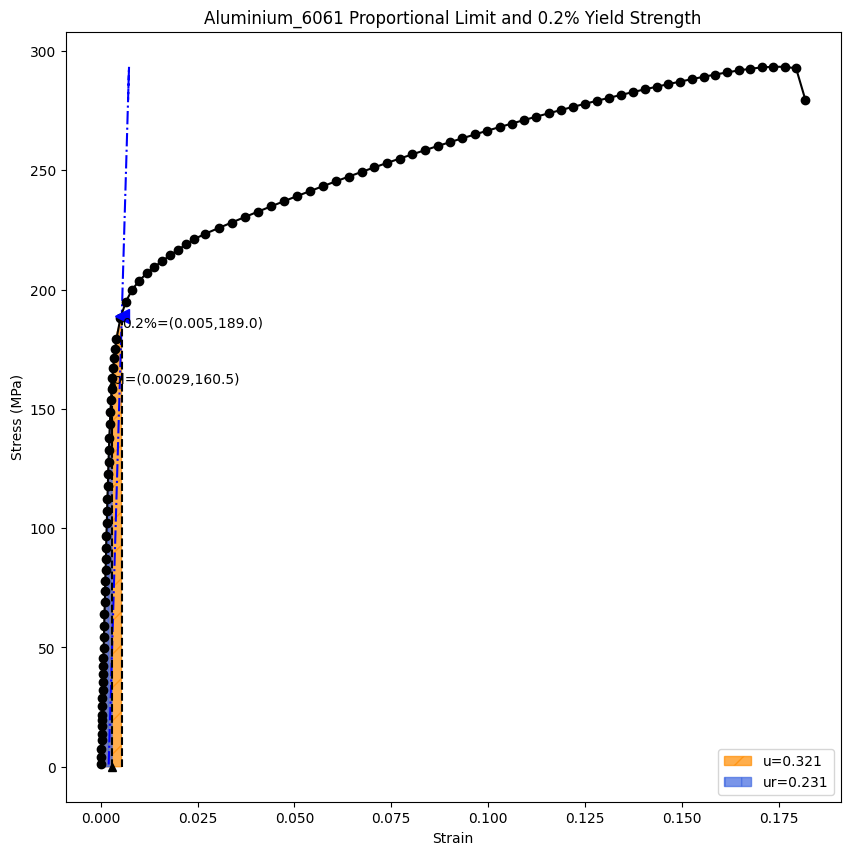

In [35]:
#Plot Moduli of Resilience
ofst2x = np.linspace(strain_offset_fine[fine_indx],strain_offset_fine[fine_indx],2)
ofst2y = np.linspace(0,stress_offset_fine[fine_indx],2)
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material_folder)+' Proportional Limit and 0.2% Yield Strength'
plt.title(figname)
#plt.xlim(0,strain[new_indx+winSize])
#plt.ylim(0,stress[new_indx+winSize])
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(strain_offset,stress_offset,color='b',linestyle='-.')
plt.plot(smooth_x,smooth_y,marker='o',color='black')
plt.plot(plx,ply,marker='^',color='black',linestyle='--')
plt.plot(ofst2x,ofst2y,color='black',linestyle='--')
plt.plot(strain_offset_fine[fine_indx],stress_offset_fine[fine_indx],marker='<',color='b',markersize=10)
plt.annotate('pl=({},{})'.format(np.round(strain[pl],4),np.round(stress[pl],1)),
                (strain[pl],stress[pl]),(strain[pl]+0.0001,stress[pl]))
plt.annotate('0.2%=({},{})'.format(np.round(strain_offset_fine[fine_indx],3),
                                       np.round(stress_offset_fine[fine_indx],1)),
                 (strain_offset_fine[fine_indx],stress_offset_fine[fine_indx]),
                 (strain_offset_fine[fine_indx]+0.0001,stress_offset_fine[fine_indx]-5))
    
plt.fill_between(strain[0:new_indx],stress[0:new_indx],color='darkorange',alpha=0.7,hatch='/',
                     label='u={}'.format(np.round(ur_offset,3)))
plt.fill_between(strain[0:pl],stress[0:pl],color='royalblue',alpha=0.7,hatch='|',
                    label='ur={}'.format(np.round(ur,3)))
plt.legend()
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()

## Calculate Modulus of Toughness
- Calculates Modulus of Toughness
- Appends result to txt file

In [36]:
"""
Modulus of Toughness
"""
#Create Rectangles
area = 0
for i in range(1,len(smooth_x)):
    w = smooth_x[i]-smooth_x[i-1]
    h = (smooth_y[i]+smooth_y[i-1])/2
    rec = w*h
    area=area+rec
print('Modulus of Toughness = {}'.format(np.round(area,3))+" "+y_units)
txtEdit('Modulus of Toughness = {}'.format(np.round(area,3))+" "+y_units+'\n','a', metadata_file_path)
    
    

Modulus of Toughness = 46.442 MPa


## Caculate UTS and Strain at Failure

- Caculates UTS 
- Caculates Strain at Failure
- Caculate elastic recovery
- Plot UTS and Strain at Failure
- Saves figure 
- Appends result to txt file

UTS=293.5 MPa
ef=0.182
er=0.1769


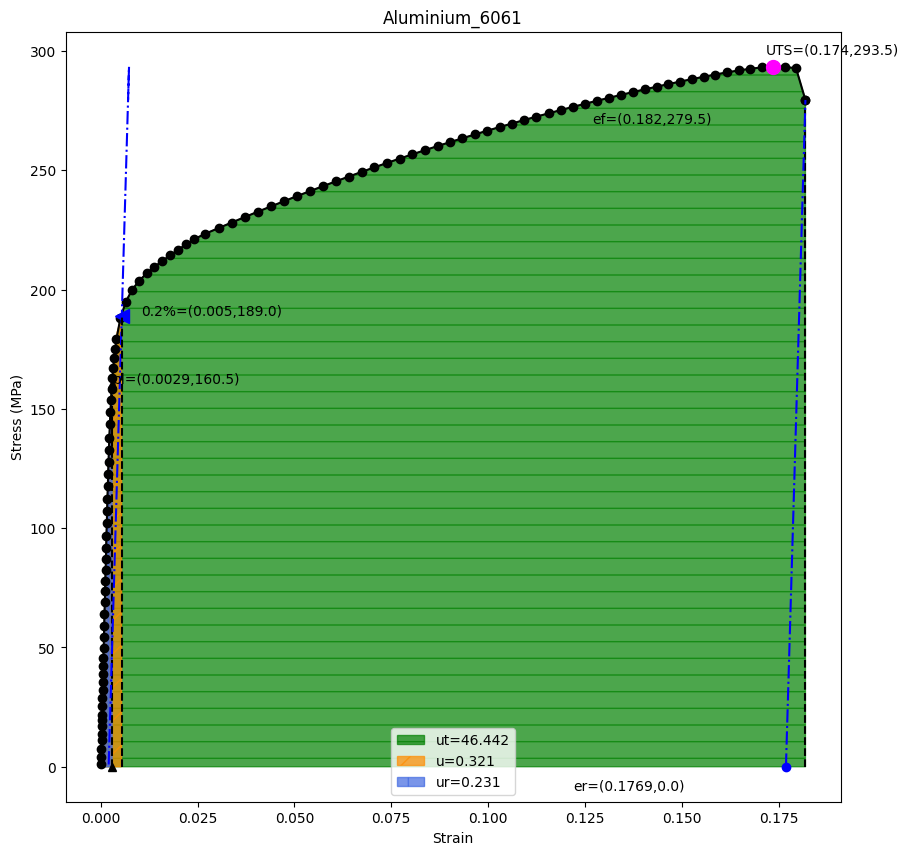

In [38]:
"""
UTS and Strain at Failure
"""
#Ultimate Tensile Strength
UTS = np.argmax(smooth_y)
#UTS = smooth_y[UTS]
print('UTS={}'.format(np.round(smooth_y[UTS],1))+" "+y_units)
txtEdit('UTS={}'.format(np.round(smooth_y[UTS],1))+" "+y_units+'\n','a', metadata_file_path)
    
#Strain at Failure
ef = np.argmax(smooth_x)
print('ef={}'.format(np.round(smooth_x[ef],4)))
txtEdit('ef={}'.format(np.round(smooth_x[ef],4))+'\n','a', metadata_file_path)
xef=np.linspace(smooth_x[ef],smooth_x[ef],2)
yef=np.linspace(0,smooth_y[ef],2)
    
#Find Elastic Recovery
tantheta = stress[pl]/strain[pl]
theta = np.arctan(tantheta)
elastic_ef = smooth_x[ef]-(smooth_y[ef]/np.tan(theta))
print('er={}'.format(np.round(elastic_ef,4)))
txtEdit('er={}'.format(np.round(elastic_ef,4))+'\n','a', metadata_file_path)
xEAF = np.linspace(elastic_ef,smooth_x[ef],2)
yEAF = np.linspace(0,smooth_y[ef],2)
    
#Plot UTS and Strain at Failure
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material_folder)
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
    
#Proportional Limit
plt.plot(plx,ply,marker='^',color='black',linestyle='--')
plt.annotate('pl=({},{})'.format(np.round(strain[pl],4),np.round(stress[pl],1)),
                 (strain[pl],stress[pl]),(strain[pl]+0.0001,stress[pl]))
    
#0.2% Offset
plt.plot(strain_offset,stress_offset,color='b',linestyle='-.')
plt.annotate('0.2%=({},{})'.format(np.round(strain_offset_fine[fine_indx],3),
                                       np.round(stress_offset_fine[fine_indx],1)),
                 (strain_offset_fine[fine_indx],stress_offset_fine[fine_indx]),
                 (strain_offset_fine[fine_indx]+0.005,stress_offset_fine[fine_indx]))
plt.plot(strain[new_indx],stress[new_indx],marker='<',color='b',markersize=10)
    
#Resilience/Elastic Strain Energy/Toughness
plt.plot(ofst2x,ofst2y,color='black',linestyle='--')
plt.fill_between(smooth_x,smooth_y,color='green',alpha=0.7,hatch='-',
                    label='ut={}'.format(np.round(area,3)))
plt.fill_between(strain[0:new_indx],stress[0:new_indx],color='darkorange',alpha=0.7,hatch='/',
                     label='u={}'.format(np.round(ur_offset,3)))
plt.fill_between(strain[0:pl],stress[0:pl],color='royalblue',alpha=0.7,hatch='|',
                    label='ur={}'.format(np.round(ur,3)))
    
#UTS and Strain at Failure
plt.plot(smooth_x[UTS],smooth_y[UTS],marker='o',markersize=10,color='magenta')
plt.annotate('UTS=({},{})'.format(np.round(smooth_x[UTS],3),np.round(smooth_y[UTS],1)),
                 (smooth_x[UTS],smooth_y[UTS]),(smooth_x[UTS]-0.002,smooth_y[UTS]+5))
plt.plot(xef,yef,color='black',linestyle='--')
plt.plot(smooth_x[ef],smooth_y[ef],marker='o',color='black')
plt.annotate('ef=({},{})'.format(np.round(smooth_x[ef],4),np.round(smooth_y[ef],1)),
                 (smooth_x[ef],smooth_y[ef]),(smooth_x[ef]-0.055,smooth_y[ef]-10))
    
plt.plot(xEAF,yEAF,color='blue',linestyle='-.')
plt.plot(xEAF[0],yEAF[0],marker='o',color='b')
plt.annotate('er=({},{})'.format(np.round(xEAF[0],4),np.round(yEAF[0],1)),
                 (xEAF[0],yEAF[0]),(xEAF[0]-0.055,yEAF[0]-10))
    
    
plt.legend()
fig.savefig(os.path.join(result_material_folder, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()
print('\n\n')


# Graph Making and Data Capture
We use the PMDco Ontology to create an RDF file that organizes and structures data from excel reports and processed results using triplets. Here's how each component contributes to organizing and structuring the data:

1. **Subject:** The subject represents the entity or variable for which information is being described. In this context, the subject corresponds to specific entities in materials testing, such as the tensile test instance. For example, `test_instance` serves as the subject when describing test results associated with a particular material.

2. **Predicate:** The predicate defines the relationship or property that connects the subject to the object in the RDF graph. It signifies how the subject and object are related. Predicates in this context include properties such as `TTO.OriginalGaugeLength`, `TTO.OriginalWidth`, `TTO.YoungsModulus`, and `CORE.PrimaryData`, specifying attributes like gauge length, width, Young's modulus, and links to primary data.

3. **Object:** The object represents the value or data associated with the subject-predicate relationship. It can be a literal value (such as strings, numbers, or dates) or a resource (such as another URI). The object provides the specific information or data being asserted in the RDF graph. For instance, `rdflib.Literal(s_length)` represents the literal value of the specimen's length, while `rdflib.URIRef("https://w3id.org/pmd/co/unit#mm")` denotes the unit of measurement.

## **Key Points** 

1. **Triplets Structure:** The RDF triplets capture and represent information about tensile testing in a structured, machine-readable format. This includes attributes such as original gauge length, width, thickness, Young's modulus, yield strength, ultimate tensile strength, and percentage extension.

2. **Clarity and Organization:** By saving raw data and processed data under different URIs (e.g., `PrimaryData_link` and `SecondaryData_link`), it's easier to distinguish between the two types of data. This separation enhances the clarity of the RDF graph structure and makes it easier for both humans and machines to understand the data model.

3. **Different Data Processing Stages:** Raw data represents the initial data captured from experiments, while processed data undergoes analysis or transformation. Storing them separately reflects their distinct stages in the data processing pipeline.

4. **Granularity and Detail:** Raw data typically contains numerous data points, whereas processed data may have fewer points but with additional derived information. Separating them allows for a clear distinction in granularity and detail.

5. **Flexibility and Modularity:** Storing data under specific URIs provides flexibility for future extensions or modifications to the data model. For example, if additional processing steps or intermediate results need to be included later, it can be done without impacting the existing structure.

In [50]:
import rdflib

# Create an RDF graph for the experimental data
data_graph = rdflib.Graph()

# Add namespaces
TTO = rdflib.Namespace("https://w3id.org/pmd/tto/")
CORE = rdflib.Namespace("https://w3id.org/pmd/co/")
data_graph.bind("tto", TTO)
data_graph.bind("core", CORE)

# Define the tensile test instance
test_instance = "https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/ReportRaw/" + material_folder + "/" + file_name
test_instance = rdflib.URIRef(test_instance)

# Add the tensile test instance to the graph
data_graph.add((test_instance, rdflib.RDF.type, TTO.TensileTest))

# Function to add property with unit as a blank node
def add_property_with_unit(graph, instance, property_uri, value, unit):
    value_node = rdflib.BNode()
    graph.add((instance, property_uri, value_node))
    graph.add((value_node, rdflib.RDF.type, CORE.ValueObject))
    graph.add((value_node, rdflib.RDF.value, rdflib.Literal(value, datatype=rdflib.XSD.float)))
    graph.add((value_node, CORE.unit, rdflib.URIRef(unit)))

# Add properties with units to the tensile test instance
add_property_with_unit(data_graph, test_instance, TTO.OriginalGaugeLength, float(s_length), "https://w3id.org/pmd/co/unit#mm")
add_property_with_unit(data_graph, test_instance, TTO.OriginalWidth, width, "https://w3id.org/pmd/co/unit#mm")
add_property_with_unit(data_graph, test_instance, TTO.OriginalThickness, thickness, "https://w3id.org/pmd/co/unit#mm")
add_property_with_unit(data_graph, test_instance, TTO.YoungsModulus, float(np.round(E,0)), "https://w3id.org/pmd/co/unit#MPa")
add_property_with_unit(data_graph, test_instance, TTO.YieldStrength, np.round(stress_offset_fine[fine_indx],3), "https://w3id.org/pmd/co/unit#MPa")
add_property_with_unit(data_graph, test_instance, TTO.UltimateTensileStrength, np.round(smooth_y[UTS],1), "https://w3id.org/pmd/co/unit#MPa")
add_property_with_unit(data_graph, test_instance, TTO.PercentageExtension, np.round(smooth_x[ef],4), "https://w3id.org/pmd/co/unit#percent")

# Add PrimaryData, SecondaryData, and MaterialDesignation as strings
PrimaryData_link = "https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/PrimaryData/"+ material_folder + "/" + file_name + ".csv"
SecondaryData_link = "https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/SecondaryData/"+ material_folder + "/" + file_name + ".csv"
data_graph.add((test_instance, CORE.PrimaryData, rdflib.Literal(PrimaryData_link, datatype=rdflib.XSD.string)))
data_graph.add((test_instance, CORE.SecondaryData, rdflib.Literal(SecondaryData_link, datatype=rdflib.XSD.string)))
data_graph.add((test_instance, CORE.MaterialDesignation, rdflib.Literal(material_folder, datatype=rdflib.XSD.string)))

# Serialize the RDF data to a TTL file
output_file =os.path.join(result_material_folder, file_name + ".ttl") 

data_graph.serialize(destination=output_file, format="turtle")

print(f"Experimental RDF data serialized to {output_file}")


Experimental RDF data serialized to D:\FAIR_Ontology\MaRCN_Tensile_Ontology\results\Aluminium_6061\Tensile_001\Tensile_001.ttl


Note: This are some methods to extract data from RDF files, and with such we ensure all dictionaries are equal, now we can compare multiple test using this methods. 

In [47]:
# Read and display the contents of the generated TTL file
with open(output_file, 'r') as file:
    ttl_content = file.read()

print(ttl_content)

@prefix core: <https://w3id.org/pmd/co/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix tto: <https://w3id.org/pmd/tto/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/ReportRaw/Aluminium_6061/Tensile_001> a tto:TensileTest ;
    core:MaterialDesignation "Aluminium_6061"^^xsd:string ;
    core:PrimaryData "https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/PrimaryData/Aluminium_6061/Tensile_001.csv"^^xsd:string ;
    core:SecondaryData "https://github.com/Wino1301/MaRCN_Tensile_Ontology/tree/main/data/SecondaryData/Aluminium_6061/Tensile_001.csv"^^xsd:string ;
    tto:OriginalGaugeLength [ a core:ValueObject ;
            rdf:value "50"^^xsd:float ;
            core:unit <https://w3id.org/pmd/co/unit#mm> ] ;
    tto:OriginalThickness [ a core:ValueObject ;
            rdf:value "3.09"^^xsd:float ;
            core:unit <https://w3id.org/pmd/co/unit#mm> ] ;
    tto:OriginalWi

In [51]:
# Load the SHACL shapes graph
from pyshacl import validate
ontology_folder = os.path.join(script_dir, 'ontology')
shapes_graph = rdflib.Graph()
shapes_graph.parse(os.path.join(ontology_folder, "tto_shapes.ttl"), format="turtle")

# Validate the experimental data against the SHACL shapes
results = validate(data_graph, shacl_graph=shapes_graph, 
                   inference='rdfs', abort_on_first=False, meta_shacl=False, advanced=True)

# Extract validation results
conforms, results_graph, results_text = results

print("Conforms:", conforms)
print("Results Text:", results_text)

Conforms: True
Results Text: Validation Report
Conforms: True

